In [31]:
import pandas as pd
pd.options.display.max_columns=200
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [32]:
data = pd.read_csv('data/btc_data.csv', index_col=0)

In [33]:
data

,high,low,open,volumefrom,volumeto,close,market_cap,progression daily,progression tomorrow,target,ema_26,ema_12,macd,rsi,relative_volume,obv,atr,bollinger_upper,bollinger_lower,k,momentum,difficulty
2011-01-01,0.3000,0.292,0.3000,2821.24,8.419500e+02,0.3000,NaN,0.000000,0.000000,0,0.251628,0.272215,0.020587,75.041736,0.433468,5.683560e+03,0.018136,0.302597,0.209763,98.360656,0.060,NaN
2011-01-02,0.3000,0.289,0.3000,5352.11,1.584660e+03,0.3000,NaN,0.000000,0.000000,0,0.255211,0.276490,0.021279,74.831650,0.784203,4.098900e+03,0.018214,0.307253,0.213107,98.360656,0.050,NaN
2011-01-03,0.3000,0.290,0.3000,1425.19,4.208500e+02,0.2950,NaN,0.000000,-0.016667,0,0.258529,0.280107,0.021578,75.402884,0.227126,3.678050e+03,0.016429,0.311694,0.215676,98.360656,0.050,NaN
2011-01-04,0.2999,0.289,0.2950,1879.00,5.483300e+02,0.2989,NaN,-0.016667,0.013220,1,0.261230,0.282398,0.021168,64.583333,0.317246,3.129720e+03,0.015286,0.315355,0.216845,90.163934,0.047,NaN
2011-01-05,0.2990,0.290,0.2989,357.16,1.061900e+02,0.2990,NaN,0.013220,0.000335,1,0.264021,0.284937,0.020916,90.397805,0.063656,3.235910e+03,0.014000,0.318771,0.219319,96.500000,0.049,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-09,37990.5100,35557.780,35638.3300,62530.57,2.296501e+09,36704.1400,6.991875e+11,0.006111,0.029906,1,32977.256229,34652.480366,1675.224137,64.490306,2.574816,2.773654e+10,1116.338571,37608.902641,30223.386359,48.691426,1102.950,6.246347e+13
2023-11-10,37536.4400,36342.270,36704.1400,32545.30,1.206041e+09,37321.5100,7.170221e+11,0.029906,0.016820,1,33253.321693,34968.120310,1714.798617,77.472798,1.334946,2.894258e+10,1173.541429,37581.355707,30952.910293,68.735235,2209.580,6.246347e+13
2023-11-11,37417.2900,36701.830,37321.5100,14920.50,5.532155e+08,37142.2200,7.307607e+11,0.016820,-0.004804,0,33554.668975,35330.180262,1775.511287,84.113197,0.603681,2.949580e+10,1180.479286,37535.474284,31738.534716,83.451695,2663.780,6.246347e+13
2023-11-12,37233.4500,36747.050,37142.2200,9320.87,3.455680e+08,37079.7600,7.203239e+11,-0.004804,-0.001682,0,33820.413496,35608.955606,1788.542111,80.518099,0.380771,2.915023e+10,1160.555714,37153.159459,32834.927541,78.426595,1702.460,6.246347e+13


In [34]:
data['open'].describe()

count     4700.000000
mean     10147.255867
std      14910.056836
min          0.295000
25%        238.517500
50%       2334.155000
75%      11869.932500
max      67549.140000
Name: open, dtype: float64

In [35]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]

In [36]:
# Définir la taille de la fenêtre initiale
window_size = 1000

In [7]:
#Test avec RandomForest

"""  
# Initialiser les listes pour stocker les prédictions et les vraies valeurs
predictions = []
actuals = []

# Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
for i in range(window_size, len(data) - 1):
    # Diviser les données en ensembles d'entraînement et de test
    X_train = features.iloc[i-window_size:i, :]
    y_train = target.iloc[i-window_size:i]
    X_test = features.iloc[i:i+1, :]
    y_test = target.iloc[i]

    #Normaliser les données
    scaler = StandardScaler()
    X_train_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Entraîner un modèle
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # Faire une prédiction
    prediction = model.predict(X_test)[0]
    
    # Stocker les prédictions et les vraies valeurs
    predictions.append(prediction)
    actuals.append(y_test)

# Évaluer le modèle
accuracy = accuracy_score(actuals, predictions)
print(f'Model Accuracy: {accuracy * 100:.2f}%')"""


"  \n# Initialiser les listes pour stocker les prédictions et les vraies valeurs\npredictions = []\nactuals = []\n\n# Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données\nfor i in range(window_size, len(data) - 1):\n    # Diviser les données en ensembles d'entraînement et de test\n    X_train = features.iloc[i-window_size:i, :]\n    y_train = target.iloc[i-window_size:i]\n    X_test = features.iloc[i:i+1, :]\n    y_test = target.iloc[i]\n\n    #Normaliser les données\n    scaler = StandardScaler()\n    X_train_train = scaler.fit_transform(X_train)\n    X_test = scaler.transform(X_test)\n    \n    # Entraîner un modèle\n    model = RandomForestClassifier()\n    model.fit(X_train, y_train)\n    \n    # Faire une prédiction\n    prediction = model.predict(X_test)[0]\n    \n    # Stocker les prédictions et les vraies valeurs\n    predictions.append(prediction)\n    actuals.append(y_test)\n\n# Évaluer le modèle\naccuracy = accuracy_score(actuals, predictions)\

In [8]:
def train_model(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      print(f'Model Accuracy: {accuracy * 100:.2f}%')

In [9]:
def train_model_f1(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      score = f1_score(actuals, predictions)
      print(f'Model Accuracy: {score * 100:.2f}%')

In [10]:
dummy_model = DummyClassifier(strategy="most_frequent")
train_model(data, dummy_model, features, target, window_size)

Model Accuracy: 52.23%


In [10]:
"""from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
train_model(data, logistic_regression, features, target, window_size)"""

'from sklearn.linear_model import LogisticRegression\nlogistic_regression = LogisticRegression()\ntrain_model(data, logistic_regression, features, target, window_size)'

In [11]:
"""xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
train_model(data, xgboost, features, target, window_size)"""

"xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')\ntrain_model(data, xgboost, features, target, window_size)"

In [37]:
def plot_feature_importance(model, feature_names):
    # Récupérer les coefficients du modèle
    coefficients = model.coef_[0]
    
    # Créer un DataFrame pour stocker les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': coefficients
    })
    
    # Trier le DataFrame en fonction de l'importance
    feature_importance = feature_importance.sort_values(by='Importance', key=abs, ascending=False)
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Feature Importance for Logistic Regression')
    plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
    plt.show()

In [38]:
def plot_feature_importance_xgb(model, feature_names):
    # Récupérer les importances des caractéristiques du modèle XGBoost
    importances = model.feature_importances_
    
    # Créer un DataFrame pour stocker les caractéristiques et leurs importances
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Trier le DataFrame en fonction de l'importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # Visualiser l'importance des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance for XGBoost')
    plt.gca().invert_yaxis()  # Pour afficher la caractéristique la plus importante en haut
    plt.show()

In [14]:
"""plot_feature_importance(logistic_regression, features.columns)"""

'plot_feature_importance(logistic_regression, features.columns)'

In [39]:
def earn_metric(predicted_probs, progressions, n_days, i):
      base = c = 1
      for j in range(n_days):
            index = len(predicted_probs) - n_days + j
            c *= predicted_probs[index] * progressions[index] + (1 - predicted_probs[index])
            base *= progressions[index]
      return c / base


def train_model_proba_metric(data, model, features, target, window_size, n_days):
      
    # Initialiser les listes pour stocker les probaabilités prédites et les vraies valeurs
    predicted_probs = []
    progressions = []
    metric = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        
        # Récupérer la progression réelle
        progressions.append(data.iloc[i]['progression tomorrow']+1)

        if i >= window_size + n_days:
            metric.append(earn_metric(predicted_probs, progressions, n_days, i))
    
    return np.mean(metric) 

In [16]:
n_days = 31

"""train_model_proba_metric(data, xgboost, features, target, window_size, n_days)"""

'train_model_proba_metric(data, xgboost, features, target, window_size, n_days)'

In [17]:
def train_model_grid(data, model, features, target, window_size):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(window_size, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[i-window_size:i, :]
            y_train = target.iloc[i-window_size:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      return accuracy

In [18]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]

In [21]:
# Définir la grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200],
    'fit_intercept': [True],
    'class_weight': [None, 'balanced']
}

In [32]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid))

# Pour boucler sur chaque combinaison :
best_accuracy = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = LogisticRegression(**params)
        
        # Appliquer la fonction train_model
        accuracy = train_model_grid(data, model_instance, features, target, window_size)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, accuracy : {accuracy}")

        else:
            print(f'Trop nul mdr : {params}, accuracy : {accuracy}"')

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        #display(HTML(f"<small>{error_message}</small>"))
        #pass

print(f"Best Model Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")

Nouveaux meilleurs paramètres trouvés : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}, accuracy : 0.47766884531590414
Nouveaux meilleurs paramètres trouvés : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}, accuracy : 0.5634531590413944
Trop nul mdr : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}, accuracy : 0.5620915032679739"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}, accuracy : 0.47766884531590414"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}, accuracy : 0.5533769063180828"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}, accur

In [22]:
#LogisticRegression

"""Best Model Accuracy: 56.97%
Best Parameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}"""

"Best Model Accuracy: 56.97%\nBest Parameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}"

In [19]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [52]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid_xgb))

# Pour boucler sur chaque combinaison :
best_accuracy = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = XGBClassifier(**params)
        
        # Appliquer la fonction train_model
        accuracy = train_model_grid(data, model_instance, features, target, window_size)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, accuracy : {accuracy}")

        else:
            print(f'Trop nul la honte : {params}, accuracy : {accuracy}"')

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        

print(f"Best Model Accuracy: {best_accuracy * 100:.5f}%")
print(f"Best Parameters: {best_params}")

Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}, accuracy : 0.5887799564270153
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}, accuracy : 0.5833333333333334"
Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, accuracy : 0.5999455337690632
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}, accuracy : 0.5923202614379085"
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, accuracy : 0.593681917211329"
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}, accuracy : 0.5874183006535948"
Nouveaux meilleurs paramètr

In [20]:
#XGBoost

"""Best Model Accuracy: 60.56645%
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"""

"Best Model Accuracy: 60.56645%\nBest Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"

In [21]:
best_params_xgb = {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

In [35]:
xgboost = XGBClassifier(**best_params_xgb)

train_model(data, xgboost, features, target, window_size)

Model Accuracy: 61.41%


In [44]:
import pickle

# Sauvegardez le modèle dans un fichier
filename = 'models/xgboost_model.pkl'
pickle.dump(xgboost, open(filename, 'wb'))

In [45]:
# Chargez le modèle à partir du disque
xgboost = pickle.load(open(filename, 'rb'))

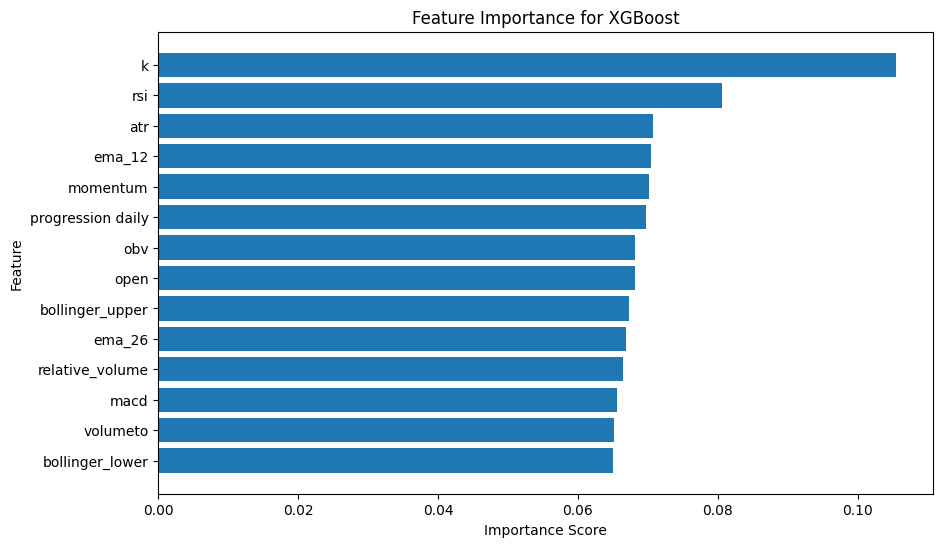

In [41]:
feature_names = features.columns.tolist()
plot_feature_importance_xgb(xgboost, feature_names)

In [26]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]
window_size = 1500
n_days = 31

In [27]:
param_grid_xgb = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [32]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid_xgb))

# Pour boucler sur chaque combinaison :
best_earning = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = XGBClassifier(**params, random_state = 42)
        
        # Appliquer la fonction train_model
        earning = train_model_proba_metric(data, model_instance, features, target, window_size, n_days)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if earning > best_earning:
            best_earning = earning
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, earning : {earning}")

        else:
            print(f'Trop nul la honte : {params}, earning : {earning}')

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        

print(f"Best Earnings: {best_earning * 100:.5f}%")
print(f"Best Parameters: {best_params}")

Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}, earning : 1.0084009335278077
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}, earning : 1.0083829500965855"
Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}, earning : 1.0205983479391452
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}, earning : 1.020363818651446"
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, earning : 1.013274166001476"
Trop nul la honte : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}, earning : 1.0135417707667784"
Nouveaux meilleurs paramètres trou

In [28]:
"""Best Model Earning: 110.36879%
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"""

"Best Model Accuracy: 110.36879%\nBest Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}"

In [42]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom', 'market_cap', 'difficulty']).iloc[:-1, :]
target = data['target'].iloc[:-1]
window_size = 1500
n_days = 31

In [44]:
best_params_xgb = {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}

xgboost = XGBClassifier(**best_params_xgb, random_state = 42)

In [45]:
train_model_proba_metric(data, xgboost, features, target, window_size, n_days)

1.0719328313078318

In [27]:
import pickle

# Sauvegardez le modèle dans un fichier
filename = 'models/xgboost_model.pkl'
pickle.dump(xgboost, open(filename, 'wb'))

In [46]:
# Chargez le modèle à partir du disque
xgboost = pickle.load(open(filename, 'rb'))

In [38]:
train_model(data, xgboost, features, target, window_size)

Model Accuracy: 60.59%


In [30]:
data_crop = data.dropna()

In [31]:
# Sélectionner les caractéristiques et exclure la dernière ligne
features = data_crop.drop(columns=['progression tomorrow', 'target', 'close', 'high', 'low', 'volumefrom']).iloc[:-1, :]
target = data['target'].iloc[:-1]

# Définir la taille de la fenêtre initiale
window_size = 1000

# Définir la taille de le fenêtre pour calculer la métrique
n_days = 31

In [41]:
dummy_model = DummyClassifier(strategy="most_frequent")
train_model(data_crop, dummy_model, features, target, window_size)

Model Accuracy: 53.29%


In [33]:
train_model_f1(data_crop, dummy_model, features, target, window_size)

Model Accuracy: 68.91%


In [42]:
# Définir la grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200],
    'fit_intercept': [True],
    'class_weight': [None, 'balanced']
}

In [43]:
"""from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid))

# Pour boucler sur chaque combinaison :
best_accuracy = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = LogisticRegression(**params)
        
        # Appliquer la fonction train_model
        accuracy = train_model_grid(data_crop, model_instance, features, target, window_size)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, accuracy : {accuracy}")

        else:
            print(f'Trop nul mdr : {params}, accuracy : {accuracy}"')

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        #display(HTML(f"<small>{error_message}</small>"))
        #pass

print(f"Best Model Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")"""

""" 20mn
Best Model Accuracy: 54.57%
Best Parameters: {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}"""

Nouveaux meilleurs paramètres trouvés : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}, accuracy : 0.46458923512747874
Nouveaux meilleurs paramètres trouvés : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}, accuracy : 0.5435552407932012
Trop nul mdr : {'C': 0.01, 'class_weight': None, 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}, accuracy : 0.5403682719546742"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l1', 'solver': 'liblinear'}, accuracy : 0.46458923512747874"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}, accuracy : 0.5354107648725213"
Trop nul mdr : {'C': 0.01, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}, accur

In [44]:
xgboost = XGBClassifier(random_state = 7)

In [45]:
param_grid_xgb_reduced = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [46]:
"""from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn')
from IPython.display import display, HTML


# Créer une liste de combinaisons de paramètres
grid_list = list(ParameterGrid(param_grid_xgb_reduced))

# Pour boucler sur chaque combinaison :
best_accuracy = 0
best_params = None

for params in grid_list:
    try:
        # Instancier le modèle avec les paramètres
        model_instance = XGBClassifier(**params)
        
        # Appliquer la fonction train_model
        accuracy = train_model_grid(data_crop, model_instance, features, target, window_size)
        
        # Si le modèle actuel a une meilleure précision que le précédent meilleur modèle, stocker sa précision et ses paramètres
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            print(f"Nouveaux meilleurs paramètres trouvés : {params}, accuracy : {accuracy}")

        
            
    except Exception as e:
        # Gérer les combinaisons de paramètres non compatibles
        error_message = f"Error with parameters {params}: {e}"
        #display(HTML(f"<small>{error_message}</small>"))
        #pass

print(f"Best Model Accuracy: {best_accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")"""

"""1h30
Best Model Accuracy: 52.97%
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}"""

Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}, accuracy : 0.5286827195467422
Nouveaux meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}, accuracy : 0.5297450424929179
Best Model Accuracy: 52.97%
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [44]:
best_params_xgb = {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

In [45]:
train_model(data_crop, xgboost, features, target, window_size)

Model Accuracy: 52.16%


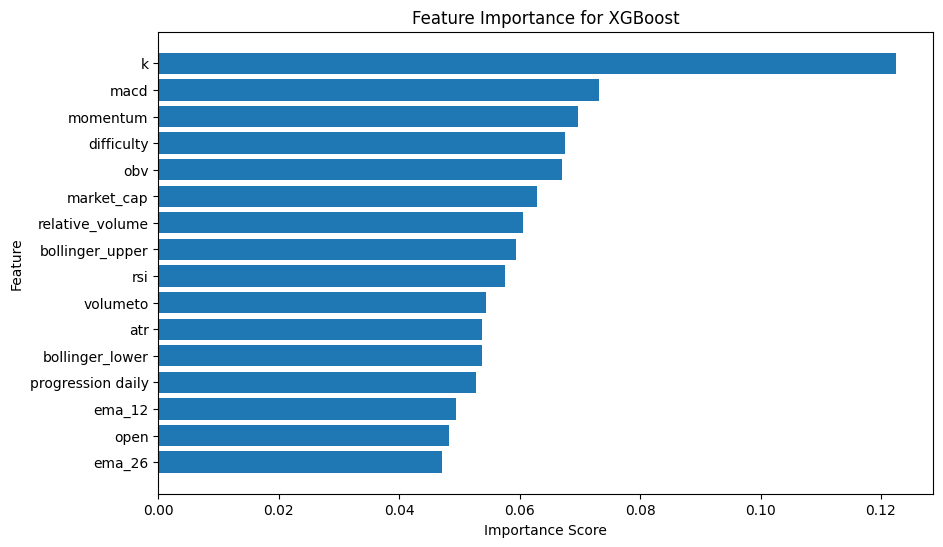

In [29]:
plot_feature_importance_xgb(xgboost, feature_names=features.columns.tolist())

In [36]:
import shap
import numpy as np
import xgboost as xgb
xgb.set_config(verbosity=0)  # 0 pour ignorer les avertissements, 1 pour les afficher


def train_model_with_shap(data, model, features, target, window_size):
      
    # Initialiser les listes pour stocker les prédictions, les vraies valeurs et les valeurs SHAP
    predictions = []
    actuals = []
    all_shap_values = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(window_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[i-window_size:i, :]
        y_train = target.iloc[i-window_size:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train_scaled, y_train)
        
        # Faire une prédiction
        prediction = model.predict(X_test_scaled)[0]
        
        # Stocker les prédictions et les vraies valeurs
        predictions.append(prediction)
        actuals.append(y_test)

        # Créez un explainer SHAP pour le modèle actuel
        explainer = shap.Explainer(model)
        
        # Calculez les valeurs SHAP pour l'ensemble d'entraînement actuel
        shap_values = explainer.shap_values(X_train_scaled)
        
        # Ajoutez les valeurs SHAP à la liste
        all_shap_values.append(shap_values)

    # Calculer l'importance moyenne des caractéristiques sur toutes les fenêtres
    mean_shap_values = np.mean(all_shap_values, axis=0)

    # Visualiser l'importance moyenne des caractéristiques
    shap.summary_plot(mean_shap_values, X_train, plot_type="bar")

    # Évaluer le modèle
    accuracy = accuracy_score(actuals, predictions)
    print(f'Model Accuracy: {accuracy * 100:.2f}%')

    return mean_shap_values


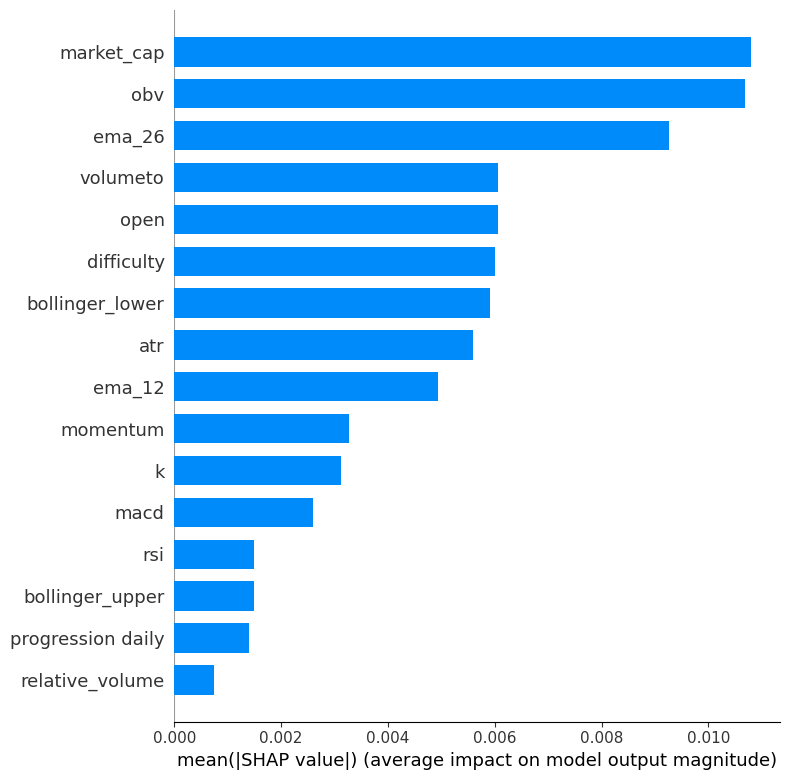

Model Accuracy: 52.02%


array([[-0.01488075,  0.0197755 , -0.02894393, ...,  0.00312517,
        -0.01000048,  0.0172015 ],
       [-0.01441185,  0.02005886, -0.02839187, ...,  0.00309581,
        -0.0100344 ,  0.01705089],
       [-0.01411395,  0.01950353, -0.02776852, ...,  0.0032432 ,
        -0.00990415,  0.01714329],
       ...,
       [-0.0009146 , -0.01106281, -0.01148989, ...,  0.00589596,
        -0.00672391,  0.00870143],
       [-0.00053631, -0.01112315, -0.01168866, ...,  0.00636024,
        -0.00641992,  0.00854722],
       [-0.00097902, -0.01088701, -0.01216247, ...,  0.00541799,
        -0.00663564,  0.00831911]], dtype=float32)

In [37]:
train_model_with_shap(data_crop, xgboost, features, target, window_size)

In [40]:
train_model_proba_metric(data_crop, xgboost, features, target, window_size, n_days)

0.9891143112128489

In [57]:
def train_model_full_data(data, model, features, target):
      
      # Initialiser les listes pour stocker les prédictions et les vraies valeurs
      predictions = []
      actuals = []

      # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
      for i in range(1, len(data) - 1):
            # Diviser les données en ensembles d'entraînement et de test
            X_train = features.iloc[:i, :]
            y_train = target.iloc[:i]
            X_test = features.iloc[i:i+1, :]
            y_test = target.iloc[i]

            #Normaliser les données
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            # Entraîner un modèle
            model.fit(X_train, y_train)
            
            # Faire une prédiction
            prediction = model.predict(X_test)[0]
            
            # Stocker les prédictions et les vraies valeurs
            predictions.append(prediction)
            actuals.append(y_test)

      # Évaluer le modèle
      accuracy = accuracy_score(actuals, predictions)
      print(f'Model Accuracy: {accuracy * 100:.2f}%')

In [37]:
def train_model_proba_metric_full_data(data, model, features, target, start_size, n_days):
      
    # Initialiser les listes pour stocker les probabilités prédites et les vraies valeurs
    predicted_probs = []
    progressions = []
    metric = []

    # Boucle à travers les données de la taille de la fenêtre jusqu'à la fin des données
    for i in range(start_size, len(data) - 1):
        # Diviser les données en ensembles d'entraînement et de test
        X_train = features.iloc[:i, :]
        y_train = target.iloc[:i]
        X_test = features.iloc[i:i+1, :]
        y_test = target.iloc[i]

        # Normaliser les données
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Entraîner un modèle
        model.fit(X_train, y_train)
        
        # Obtenir les probabilités prédites pour la classe positive (par exemple, 1)
        prediction_prob = model.predict_proba(X_test)[:, 1]
        
        # Stocker les probabilités prédites et les vraies valeurs
        predicted_probs.extend(prediction_prob)
        
        # Récupérer la progression réelle
        progressions.append(data.iloc[i]['progression tomorrow']+1)

        if i >= start_size + n_days:
            metric.append(earn_metric(predicted_probs, progressions, n_days, i))
    
    return np.mean(metric) 

In [38]:
start_size = 100

In [39]:
train_model_proba_metric_full_data(data_crop, xgboost, features, target, start_size, n_days)

0.9974486854766565